# Explain the Best Model
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import scored data
* Use Shapley Value to explain the model

# 1. Parameters

In [106]:
#Copiar o caminho path_model_mojo do step "5. Exporting the best model to Deploy" no código "2_Fast_Machine_Learning.ipynb"
path_model_mojo = '/home/sagemaker-user/clevertech-NewsNow/clusters-segmentation/user-segmentation/output_model/models/best/KMeans_model_python_1668687361081_1.zip'

#Name
ModelName = 'user_segmentation_model'

#Setting the VarId and VarDate parameters
VarId = 'id'
VarDate = 'ReferenceDate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#ATTENTION: bucket name created in S3
bucket = 'now-app-media-service'


#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#It is necessary to define the types of variables (cageroric and numeric) to ensure that the type of data used in the modeling will be the most suitable.
#For example, categorical variables need to be defined as a string because this prevents it from being treated as a numeric variable in H20 modeling
#Another example is that the string variables will have a missing treatment by placing the missing category for all values found as 'null'
CAT = []

#float
NUM = ['relevanceScore'
       ,'age'
       ,'headlineWordCount'
       ,'postTextWordCount'
       ,'tagsWordCount']
selected_features = CAT + NUM

# 2. Import Libraries

In [107]:
try:
    import sys
    sys.path.append('/var/lang/lib/python37.zip')
    sys.path.append('/var/lang/lib/python3.7')
    sys.path.append('/var/lang/lib/python3.7/lib-dynload')
    sys.path.append('/var/lang/lib/python3.7/site-packages')
    sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')
except:
    pass

In [108]:
import datetime as dt
import pandas as pd
import numpy as np
import boto3
import awswrangler as wr
import matplotlib.pyplot as plt
import shap
import h2o
import seaborn as sns

# 3. Importing Scored Data for Explain Modeling

In [109]:
#Criar conexão com o Athena
my_boto3_session = boto3.Session(region_name='us-east-1')

In [110]:
query4="select * from nowapp.%s" % ModelName+'_scored'
datascored_df_full = wr.athena.read_sql_query(query4, database="nowapp", boto3_session=my_boto3_session).rename(columns={
                   'likedrecommendation' : 'likedRecommendation',
                   'posttextwordcount' : 'postTextWordCount',
                   'relevancescore' : 'relevanceScore',
                   'tagswordcount' : 'tagsWordCount',
                   'headlinewordcount' : 'headlineWordCount',
                   'referencedate' : 'ReferenceDate'
                  })

In [111]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    datascored_df = datascored_df_full.copy()
else:
    datascored_df = datascored_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del datascored_df_full

In [112]:
#Numeric features must be float type
for col_name in NUM:
    datascored_df[col_name] = datascored_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    datascored_df[col_name] = datascored_df[col_name].astype(str)

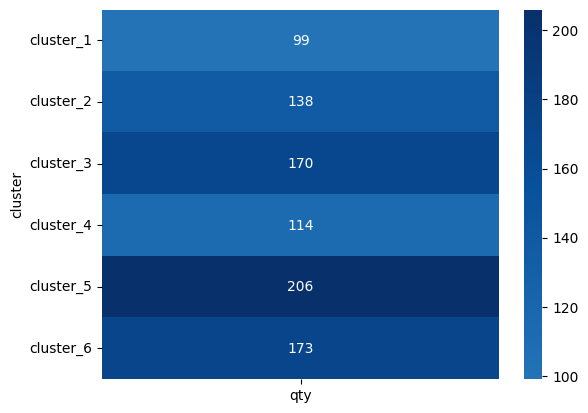

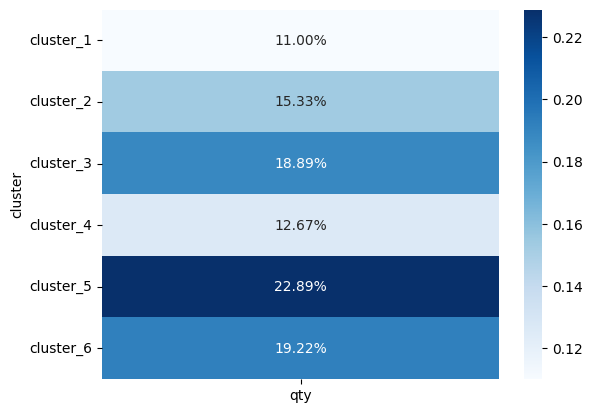

In [113]:
df_cluster_plot = datascored_df.reset_index().groupby(['cluster']).count()[['index']].rename(columns={'index': 'qty'})
sns.heatmap(df_cluster_plot, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_cluster_plot/np.sum(df_cluster_plot), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 4. Calculate Shapley Values using SHAP KernelExplainer for H20 models

#### The SHAP library calculates the Shaley Value of each variable used in the model and shows the individual impact of each variable on the predicted value for each record. To better understand how the SHAP library works, see the link https://github.com/slundberg/shap

## 4.1 For calculating the shapley value, we need to create a multiclass classification model using the clusters as the target featrure

In [114]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '4G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,6 hours 48 mins
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 9 days !!!
H2O_cluster_name:,H2O_from_python_unknownUser_c4ldpd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.448 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [115]:
#Setting the model target variable name
VarTarget = 'cluster'

#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(datascored_df.query('partition_0 == "train_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 640
Validation: 65


In [116]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(datascored_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 195


In [117]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*1

#Define metrics to select the best model in AutoML
sort_metric = 'rmse'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
19:04:51.416: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:01:03.123351



In [118]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,rmse,mean_per_class_error,logloss,mse
DRF_1_AutoML_2_20221117_190451,0.0679379,0.00666667,0.0295352,0.00461555
StackedEnsemble_BestOfFamily_1_AutoML_2_20221117_190451,0.0716021,0.00666667,0.0459176,0.00512687
GBM_1_AutoML_2_20221117_190451,0.0716115,0.00666667,0.079248,0.0051282
GLM_1_AutoML_2_20221117_190451,0.0780068,0.0105426,0.0261559,0.00608506
XGBoost_2_AutoML_2_20221117_190451,0.0861891,0.00666667,0.0660984,0.00742856
XGBoost_1_AutoML_2_20221117_190451,0.113237,0.00666667,0.0962636,0.0128226
GBM_3_AutoML_2_20221117_190451,0.390358,0.00666667,0.494787,0.152379
GBM_4_AutoML_2_20221117_190451,0.445481,0.00666667,0.591182,0.198454
GBM_2_AutoML_2_20221117_190451,0.486888,0.00666667,0.668471,0.23706
StackedEnsemble_BestOfFamily_2_AutoML_2_20221117_190451,0.589478,0.00666667,0.9204,0.347484


In [119]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_2_20221117_190451


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,9.0,54.0,8843.0,2.0,11.0,4.759259,3.0,20.0,8.462963




ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.01287391370344689
RMSE: 0.11346327028358953
LogLoss: 0.2014567424945821
Mean Per-Class Error: 0.008507295173961841
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,Error,Rate
0,74.0,0.0,1.0,0.0,0.0,0.0,0.013333,1 / 75
1,1.0,96.0,0.0,0.0,2.0,0.0,0.030303,3 / 99
2,0.0,0.0,118.0,0.0,0.0,0.0,0.000000,0 / 118
3,0.0,0.0,0.0,76.0,0.0,0.0,0.000000,0 / 76
4,0.0,1.0,0.0,0.0,134.0,0.0,0.007407,1 / 135
5,0.0,0.0,0.0,0.0,0.0,123.0,0.000000,0 / 123
6,75.0,97.0,119.0,76.0,136.0,123.0,0.007987,5 / 626



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.992013
1,2,0.996805
2,3,0.996805
3,4,0.996805
4,5,0.996805
5,6,1.000000



ModelMetricsMultinomial: drf
** Reported on validation data. **

MSE: 0.004035585875295643
RMSE: 0.06352626130424836
LogLoss: 0.031371436490305674
Mean Per-Class Error: 0.0
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,Error,Rate
0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0 / 6
1,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0 / 10
2,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0 / 6
3,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0 / 10
4,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0 / 17
5,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0 / 16
6,6.0,10.0,6.0,10.0,17.0,16.0,0.0,0 / 65



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,1.0



ModelMetricsMultinomial: drf
** Reported on cross-validation data. **

MSE: 0.0056528882438549805
RMSE: 0.07518569174952759
LogLoss: 0.03664195610377804
Mean Per-Class Error: 0.00424412049698666
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,Error,Rate
0,77.0,0.0,0.0,0.0,0.0,0.0,0.000000,0 / 77
1,0.0,100.0,0.0,0.0,1.0,0.0,0.009901,1 / 101
2,1.0,0.0,120.0,0.0,0.0,0.0,0.008264,1 / 121
3,0.0,0.0,0.0,79.0,0.0,0.0,0.000000,0 / 79
4,0.0,1.0,0.0,0.0,136.0,0.0,0.007299,1 / 137
5,0.0,0.0,0.0,0.0,0.0,125.0,0.000000,0 / 125
6,78.0,101.0,120.0,79.0,137.0,125.0,0.004687,3 / 640



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.995313
1,2,1.000000
2,3,1.000000
3,4,1.000000
4,5,1.000000
5,6,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.995313,0.006988,0.992188,0.984375,1.000000,1.000000,1.000000
1,auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,err,0.004687,0.006988,0.007812,0.015625,0.000000,0.000000,0.000000
3,err_count,0.600000,0.894427,1.000000,2.000000,0.000000,0.000000,0.000000
4,logloss,0.036642,0.015373,0.032891,0.059176,0.037361,0.016103,0.037680
5,max_per_class_error,0.018908,0.027149,0.035714,0.058824,0.000000,0.000000,0.000000
6,mean_per_class_accuracy,0.995658,0.006882,0.994048,0.984244,1.000000,1.000000,1.000000
7,mean_per_class_error,0.004342,0.006882,0.005952,0.015756,0.000000,0.000000,0.000000
8,mse,0.005653,0.004206,0.007351,0.012157,0.004130,0.001622,0.003004
9,pr_auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2022-11-17 19:05:49,0.310 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2022-11-17 19:05:49,0.331 sec,5.0,0.117878,0.372844,0.008636,NaN,NaN,0.045039,0.013231,0.0,NaN,NaN
2,,2022-11-17 19:05:49,0.346 sec,9.0,0.113463,0.201457,0.007987,NaN,NaN,0.063526,0.031371,0.0,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,relevanceScore,1653.819824,1.000000,0.496871
1,age,1224.237915,0.740249,0.367808
2,postTextWordCount,218.578583,0.132166,0.065669
3,headlineWordCount,141.186890,0.085370,0.042418
4,tagsWordCount,90.648712,0.054812,0.027234


In [121]:
h2o_predict = best_AutoML.predict(test_hdf)
df_predict = h2o_predict.cbind(test_hdf).as_data_frame()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [50]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [51]:
import lightgbm as lgb

In [52]:
params = lgb.LGBMClassifier().get_params()
params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [57]:
params['objective'] = 'cluster' # the target to predict is the number of the cluster
params['is_unbalance'] = True
params['n_jobs'] = -1
params['random_state'] = 1301

In [58]:
mdl = lgb.LGBMClassifier(**params)

In [79]:
X =  datascored_df.query('partition_0 == "train_data"').loc[:, (selected_features)]
y =  datascored_df.query('partition_0 == "train_data"').loc[:, ([VarTarget])].values.ravel()

In [81]:
mdl.fit(X, y)

LGBMClassifier(is_unbalance=True, objective='cluster', random_state=1301)

In [84]:
y_pred = mdl.predict_proba(X)

In [85]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X)

In [142]:
y_pred

array([[9.99991249e-01, 8.56915652e-07, 2.69913105e-06, 3.85139242e-06,
        6.21202739e-07, 7.22264862e-07],
       [9.99988446e-01, 1.48473337e-06, 4.67664473e-06, 3.20372540e-06,
        1.07632588e-06, 1.11235206e-06],
       [9.99989037e-01, 1.35478093e-06, 2.63734835e-06, 4.97410356e-06,
        9.82119661e-07, 1.01499257e-06],
       ...,
       [1.78468468e-06, 1.95307613e-06, 1.96631583e-06, 1.84734494e-06,
        2.02412813e-06, 9.99990424e-01],
       [7.95138108e-07, 9.99992611e-01, 5.05917024e-07, 3.05117361e-06,
        2.43097661e-06, 6.05426683e-07],
       [1.86088400e-06, 1.68110001e-06, 1.18400609e-06, 9.99992639e-01,
        1.21861567e-06, 1.41689226e-06]])

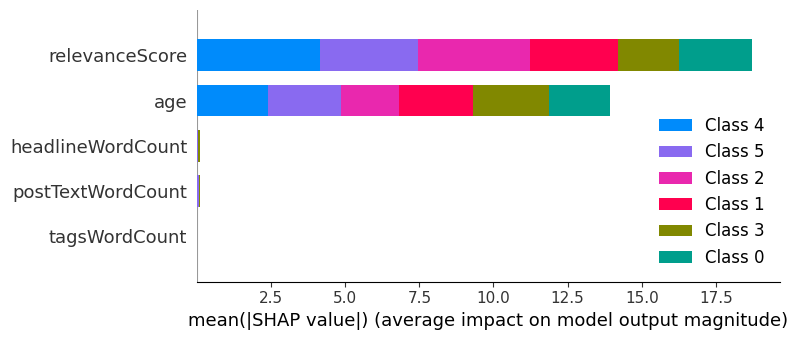

In [86]:
shap.summary_plot(shap_values, X, max_display=30)

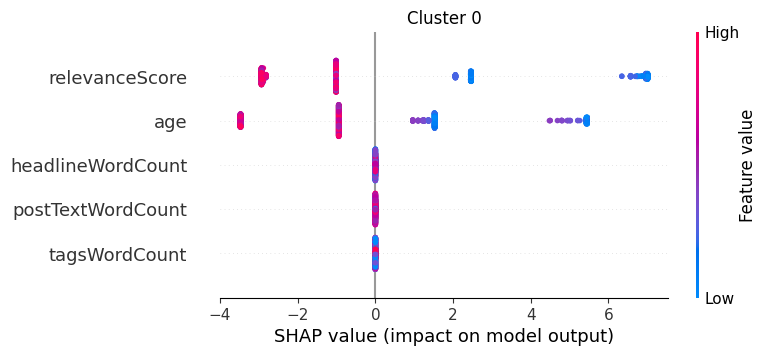

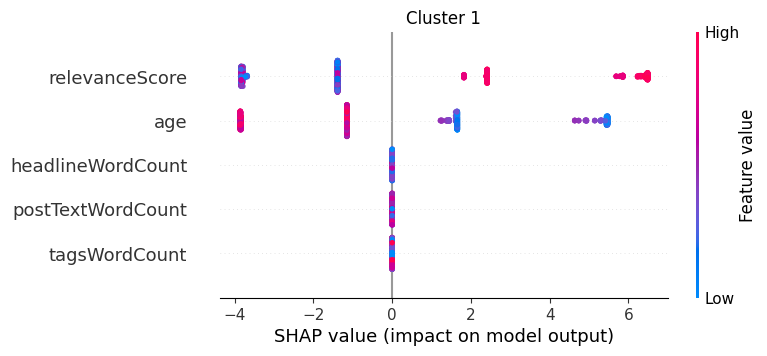

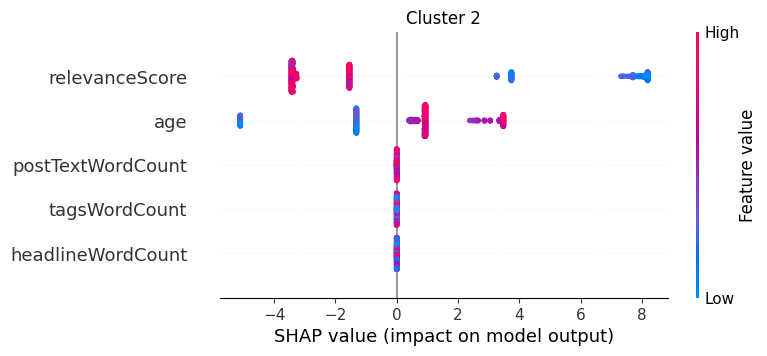

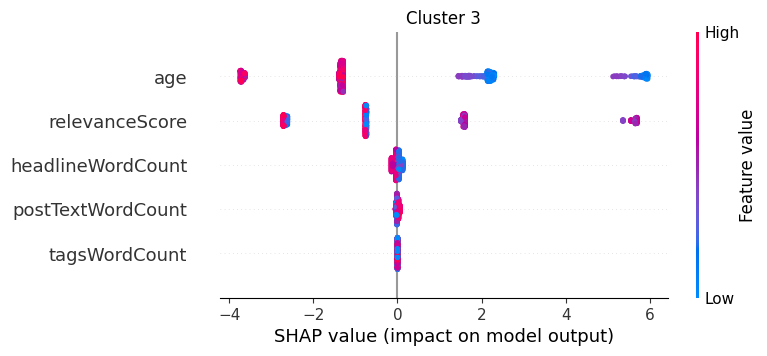

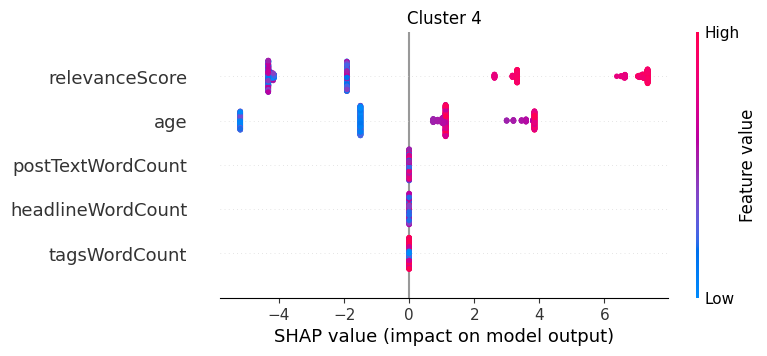

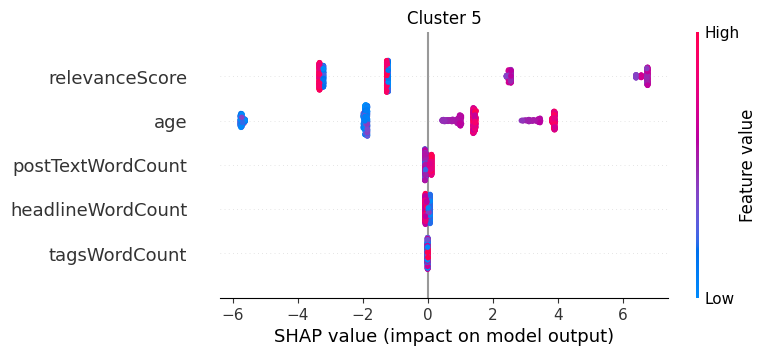

In [137]:
for cnr in range(len(datascored_df['cluster'].unique())):
    shap.summary_plot(shap_values[cnr], X, max_display=30, show=False)
    plt.title(f'Cluster {cnr}')
    plt.show()

In [145]:
def plot_cluster(df, selected_columns, clusternr):
    points = alt.Chart(df).mark_circle(size=60).encode(
    x=alt.X('pca1', title='Principal component 1 (pca1)'),
    y=alt.Y('pca2', title='Principal component 2 (pca1)'),
    color = alt.condition(alt.FieldEqualPredicate(field='cluster', equal=clusternr), 'cluster:N', alt.value('lightgray')),
    tooltip = list(all_features)+['cluster'],
)

    boxplots = alt.vconcat()
    for measure in  [c for c in selected_columns]:
        boxplot = alt.Chart(df).mark_boxplot().encode(
                x =alt.X(measure, axis=alt.Axis(titleX=480, titleY=0)),
        ).transform_filter(
                alt.FieldEqualPredicate(field='cluster', equal=clusternr)
        )
        boxplots &= boxplot
    return points, boxplots

In [147]:
[X.columns[i] for i in selected_features][::-1][:6]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [146]:
cnr = 2
feature_order = np.argsort(np.sum(np.abs(shap_values[cnr]), axis=0))
points, boxplots = plot_cluster(datascored_df, [X.columns[i] for i in selected_features][::-1][:6], cnr)
c2 = alt.hconcat(points, boxplots).properties(title=f'Cluster {cnr}')
c2

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [144]:
cnr = 0
feature_order = np.argsort(np.sum(np.abs(shap_values[cnr]), axis=0))
points, boxplots = plot_cluster(datascored_df, [X.columns[i] for i in selected_features][::-1][:6], 0)
c0 = alt.hconcat(points, boxplots).properties(title='Cluster 0')
c0

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
test_hdf = h2o.H2OFrame(datascored_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])])

In [132]:
#Funcao para calcular o valor de shapley
class H2oProbWrapper:
    def __init__(self, h2o_model, feature_names, NUM, CAT):
        self.h2o_model = h2o_model
        self.feature_names = feature_names
        self.NUM = NUM
        self.CAT = CAT
    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1) 
        self.dataframe = pd.DataFrame(X, columns=self.feature_names)

        #Numeric features must be float type
        for col_name in self.NUM:
            self.dataframe[col_name] = self.dataframe[col_name].astype(float)

        #Categorical features must be string type and null values will be filled with "Missing"
        for col_name in self.CAT:        
            self.dataframe = self.dataframe.astype(str)
            self.dataframe = self.dataframe.fillna(value={col_name: 'Missing'})

        self.predictions = h2o.mojo_predict_pandas(self.dataframe.set_index(self.feature_names[0], inplace=False), mojo_zip_path=self.h2o_model, verbose=False)
        return self.predictions[['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6']].astype('float64').values

In [124]:
shap_sample

,relevanceScore,age,headlineWordCount,postTextWordCount,tagsWordCount
132,58,69,5,27,1
16,3,28,3,27,2
18,75,46,7,21,2
51,82,49,4,27,3
164,55,31,4,25,5
145,25,26,6,26,3
11,5,45,5,21,1
27,70,69,3,25,3
176,85,48,6,17,3
118,38,56,5,26,4


In [123]:
#The calculation of the Shapley Value for H20 models takes a while. So it will only be done for 20 records. Increase the sample to deepen your analysis
shap_sample = df_predict.loc[:,(selected_features)].sample(n=50, replace=False, random_state=1)
shap_sample = shap_sample.fillna(0)

In [126]:
path_model_mojo = best_AutoML.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
path_model_mojo

'/home/sagemaker-user/clevertech-NewsNow/clusters-segmentation/user-segmentation/output_model/models/best/DRF_1_AutoML_2_20221117_190451.zip'

In [128]:
predictions = h2o.mojo_predict_pandas(df_predict.set_index('age', inplace=False), mojo_zip_path=path_model_mojo, verbose=False)
predictions

Detected 7 unused columns in the input data set: {cluster_5,cluster_6,cluster_3,cluster_4,cluster_1,cluster_2,predict}


,predict,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
0,cluster_3,0.044444,0.0,0.955556,0.000000,0.0,0.000000
1,cluster_6,0.000000,0.0,0.000000,0.048271,0.0,0.951729
2,cluster_3,0.048611,0.0,0.951389,0.000000,0.0,0.000000
3,cluster_3,0.000000,0.0,1.000000,0.000000,0.0,0.000000
4,cluster_1,1.000000,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
190,cluster_6,0.000000,0.0,0.000000,0.000000,0.0,1.000000
191,cluster_3,0.000000,0.0,1.000000,0.000000,0.0,0.000000
192,cluster_5,0.000000,0.0,0.000000,0.000000,1.0,0.000000
193,cluster_2,0.000000,1.0,0.000000,0.000000,0.0,0.000000


In [133]:
h2o_wrapper = H2oProbWrapper(path_model_mojo, selected_features, NUM, CAT)
h2o_explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, shap_sample)
h2o_shap_values = h2o_explainer.shap_values(shap_sample, nsamples="auto")

  0%|          | 0/50 [00:00<?, ?it/s]

## 4.1 Main SHAP Graphics

6

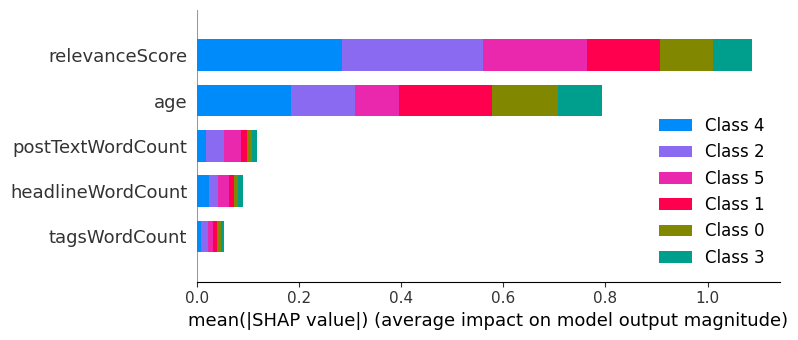

None

In [134]:
fig = shap.summary_plot(h2o_shap_values, shap_sample, plot_type="bar", show=True)
display(fig)

None

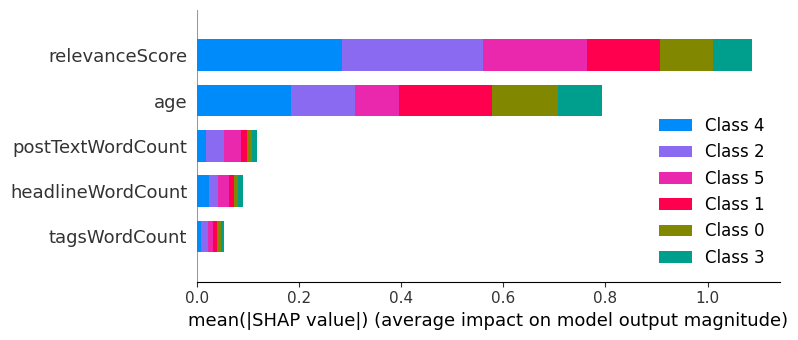

In [135]:
display(shap.summary_plot(h2o_shap_values, shap_sample, show=False))

In [136]:
#sort the features indexes by their importance in the model
#(sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(h2o_shap_values),0))

#make SHAP plots of the three most important features
for i in range(len(selected_features)):
    fig=shap.dependence_plot(top_inds[i], h2o_shap_values, shap_sample, show=False)
#     display(fig)

TypeError: The passed shap_values are a list not an array! If you have a list of explanations try passing shap_values[0] instead to explain the first output class of a multi-output model.

## 4.2 Shap Force Plot

In [18]:
df_shap_values = pd.DataFrame(h2o_shap_values)
df_shap_values['sum_shap'] = df_shap_values.sum(axis=1)

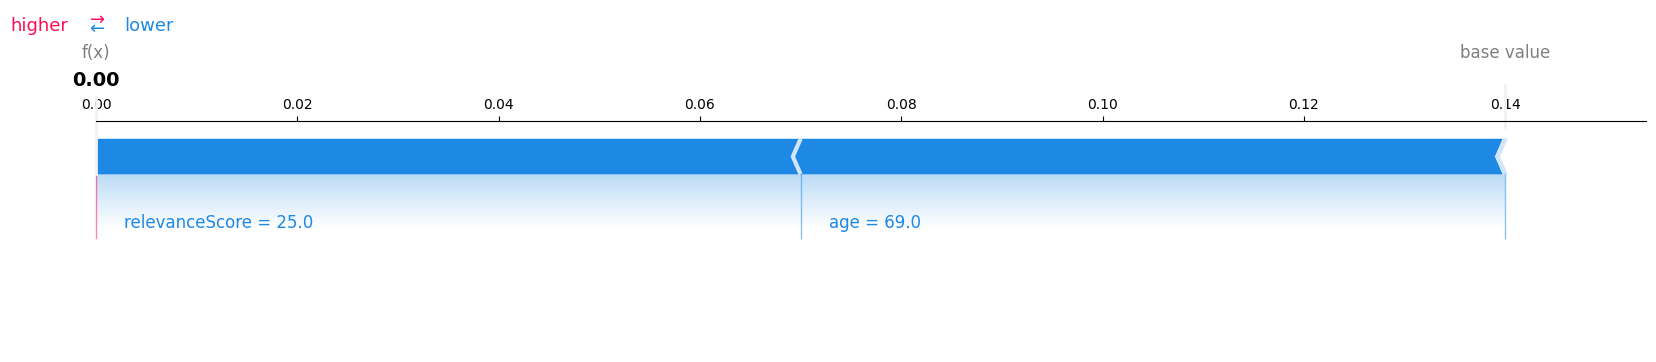

None

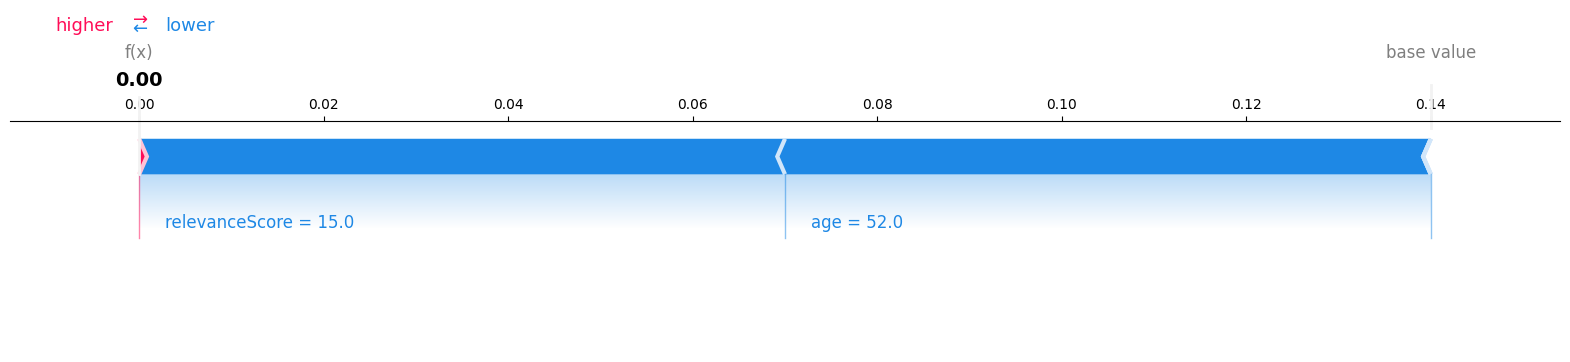

None

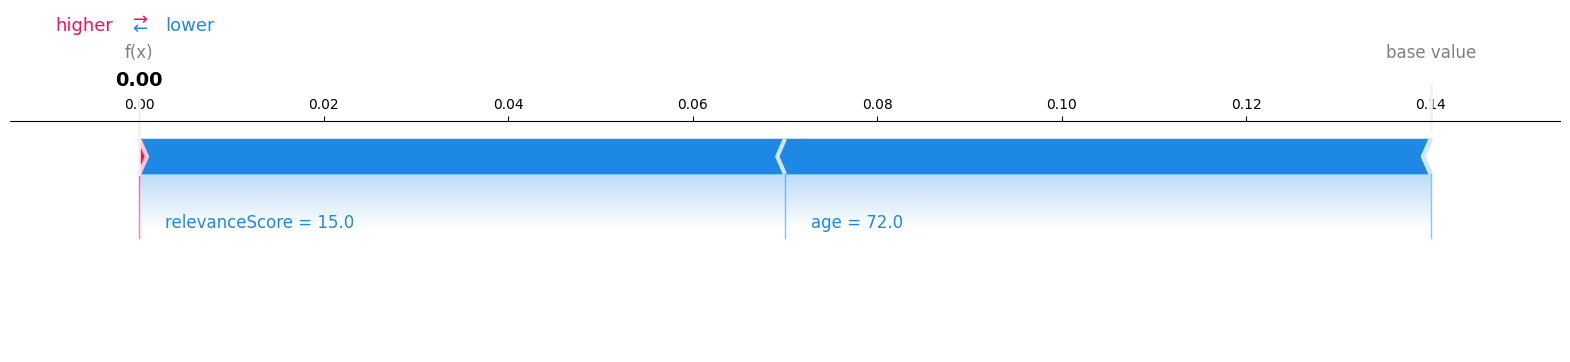

None

In [19]:
for i in df_shap_values.sort_values(by='sum_shap').iloc[0:3,:].index.values:
    fig = shap.force_plot(h2o_explainer.expected_value, h2o_shap_values[i,:], shap_sample.iloc[i,:], matplotlib=True, show=True)
    display(fig)

## 4.3 Shap Waterfall Plot

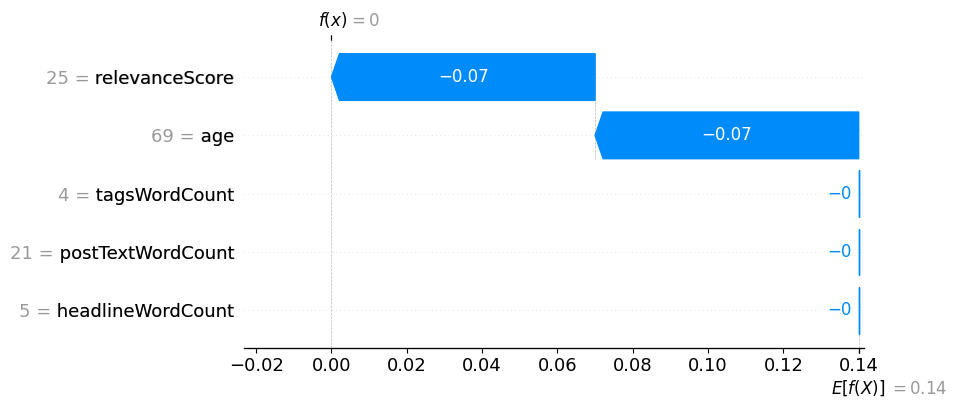

None

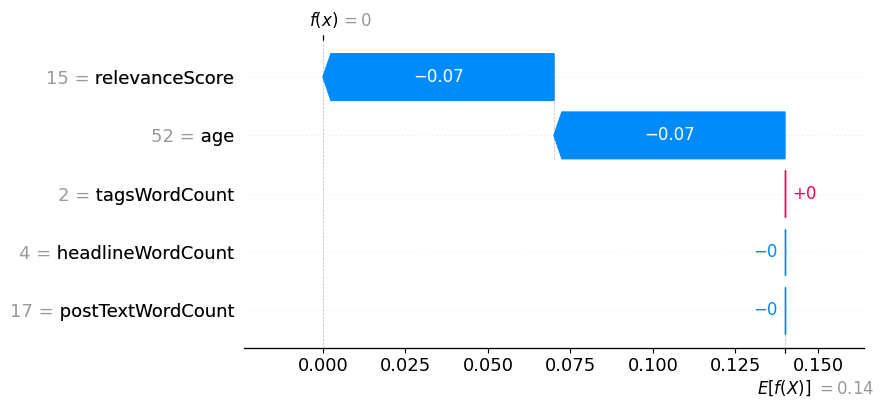

None

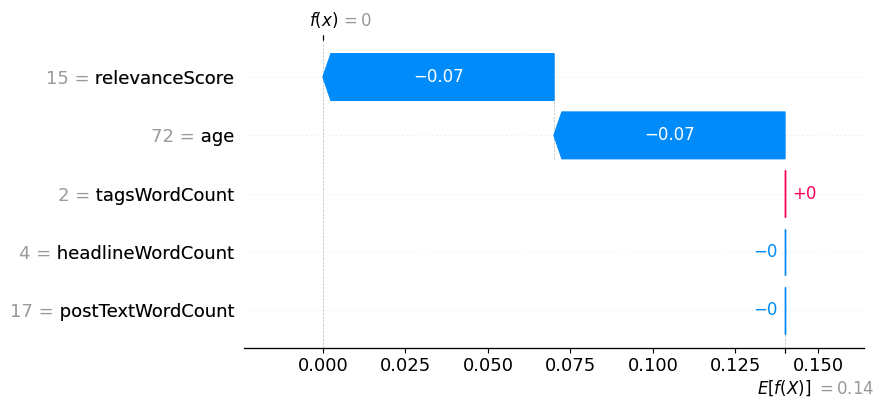

None

In [20]:
for i in df_shap_values.sort_values(by='sum_shap').iloc[0:3,:].index.values:
    fig = shap.plots._waterfall.waterfall_legacy(h2o_explainer.expected_value, h2o_shap_values[i,:], shap_sample.iloc[i,:].to_numpy(), selected_features, show=True)
    display(fig)

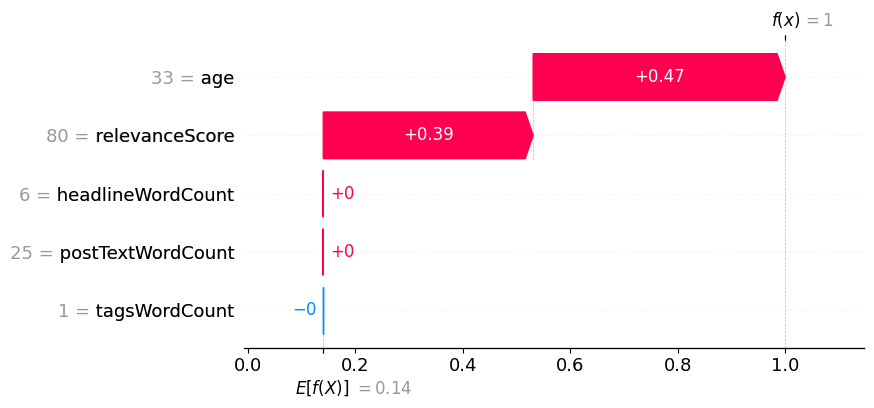

None

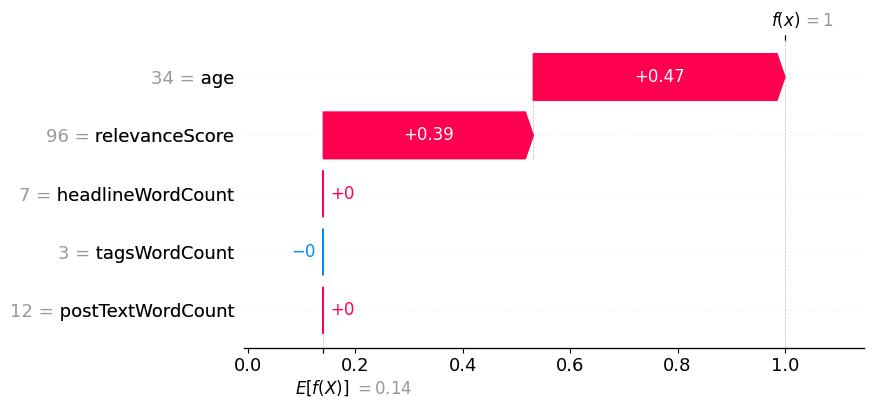

None

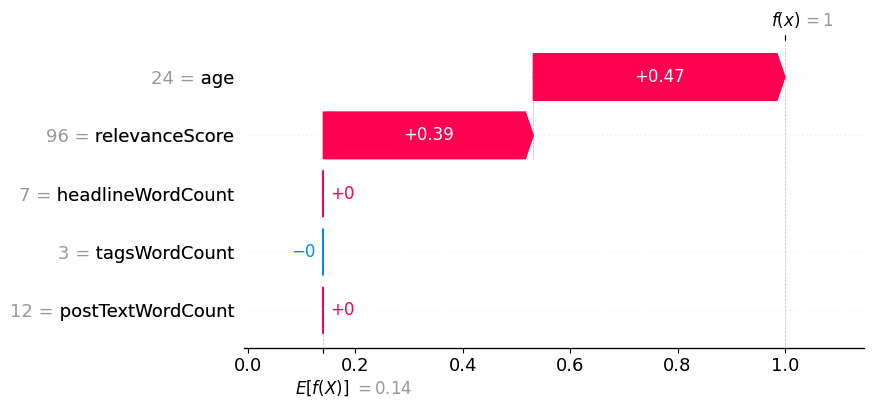

None

In [21]:
for i in df_shap_values.sort_values(by='sum_shap', ascending=False).iloc[0:3,:].index.values:
    fig = shap.plots._waterfall.waterfall_legacy(h2o_explainer.expected_value, h2o_shap_values[i,:], shap_sample.iloc[i,:].to_numpy(), selected_features, show=True)
    display(fig)

# 5. Define Ratings with homogeneous group

In [25]:
def calculate_IV(dataframe, coluna_feature, coluna_target, cat_goods = None, buckets=20):
    '''
    Function to calculate the IV.
         Parameters
         dataframe: DataFrame with the input and target variables.
         column_feature (str): Name of the variable that contains the independent variable.
         column_target (str): Name of the variable that contains the dependent variable or target.
         cat_goods (str): Level of the target variable that should be considered "GOOD", if it is categorical.
         buckets (int): Number of partitions to be created in numeric variables.
    
    Returns
    stats (list):
    List with:
        [1] IV
        [0] dataframe pandas with statistics table
    '''
    
    # Initial definitions
    df = dataframe.loc[:,(coluna_feature, coluna_target)]
    tpVar = 'categorical'    
    
    #If the variable is numeric (float or int), it creates a category for discretization
    if df[coluna_feature].dtype=='float64' or df[coluna_feature].dtype=='int64' or df[coluna_feature].dtype=='int32' or df[coluna_feature].dtype=='float32':
        tpVar='numeric'
        coluna_feature_bucket = coluna_feature + "_bucket"
        #create buckets using qcut
        df[coluna_feature_bucket] = pd.qcut(df[coluna_feature], buckets, labels=False, duplicates='drop')
        analyse_df = df.groupby(coluna_feature_bucket).agg({coluna_target: ['count', 'sum'], coluna_feature: ['min', 'max']})
        analyse_df.columns = ['_'.join(tup).rstrip('_') for tup in analyse_df.columns.values]
        analyse_df.rename(columns={(coluna_target+'_count'):'qty', (coluna_target+'_sum'):'qty_goods'}, inplace=True)
        
    #Categorical variables
    if tpVar == 'categorical':
        analyse_df = df.groupby(coluna_feature).agg({coluna_target: ['count', 'sum']})
        analyse_df.columns = ['_'.join(tup).rstrip('_') for tup in analyse_df.columns.values]
        analyse_df.rename(columns={(coluna_target+'_count'):'qty', (coluna_target+'_sum'):'qty_goods'}, inplace=True)
        
    #IV Calculation
    analyse_df.loc[:, 'qty_bads'] = analyse_df.loc[:,'qty'] - analyse_df.loc[:,'qty_goods']
    analyse_df.loc[:, 'tot_goods'] = analyse_df.loc[:,'qty_goods'].sum()
    analyse_df.loc[:, 'tot_bads'] = analyse_df.loc[:,'qty_bads'].sum()
    analyse_df.loc[:, 'perc_goods'] = analyse_df.loc[:,'qty_goods'] / analyse_df.loc[:,'tot_goods']
    analyse_df.loc[:, 'perc_bads'] = analyse_df.loc[:,'qty_bads'] / analyse_df.loc[:,'tot_bads']
    analyse_df.loc[:, 'good_rate'] = analyse_df.loc[:,'qty_goods'] / analyse_df.loc[:,'qty']
    analyse_df.loc[:, 'odds'] = analyse_df.loc[:,'perc_goods'] / analyse_df.loc[:,'perc_bads']
    analyse_df.loc[:, 'ln_odds'] = np.log2(analyse_df['odds'])
    analyse_df.loc[:, 'iv_cat'] = (analyse_df.loc[:,'perc_goods'] / analyse_df.loc[:,'perc_bads']) * analyse_df.loc[:, 'ln_odds']
    
    if tpVar == 'numeric':
        analyse_df.reset_index(inplace=True)
        tabela_pdf = analyse_df.loc[:, (coluna_feature_bucket, coluna_feature+"_min", coluna_feature+"_max", 'qty', 'good_rate', 'odds', 'iv_cat')]
    else:
        analyse_df.reset_index(inplace=True)
        tabela_pdf = analyse_df.loc[:, (coluna_feature, 'qty', 'good_rate', 'odds', 'iv_cat')]
        
    df_iv = tabela_pdf.query('iv_cat != inf')['iv_cat'].sum()
    resultado = [df_iv, tabela_pdf]
    return resultado

def colunas_dataframe(dataframe):
    lista_colunas = []
    lista_colunas = [i for i in dataframe.columns if i in selected_features]
    return lista_colunas

def table_iv(dataframe):
    lista_colunas = colunas_dataframe(dataframe)
    dict_resultados = {}
    for col in lista_colunas:
        print("{0:.0%}".format((lista_colunas.index(col)+1) / (len(lista_colunas)+1)) + ":" + col)              
        dict_resultados[col] = calculate_IV(dataframe=dataframe, coluna_feature=col, coluna_target=VarTarget, buckets=10)
    return dict_resultados

In [26]:
#Calcular Taxa de Bons, IV, ODDS e WOE
IV_p1=calculate_IV(dataframe=datascored_df, coluna_feature='p1', coluna_target=VarTarget, buckets=20)
#IV_p1

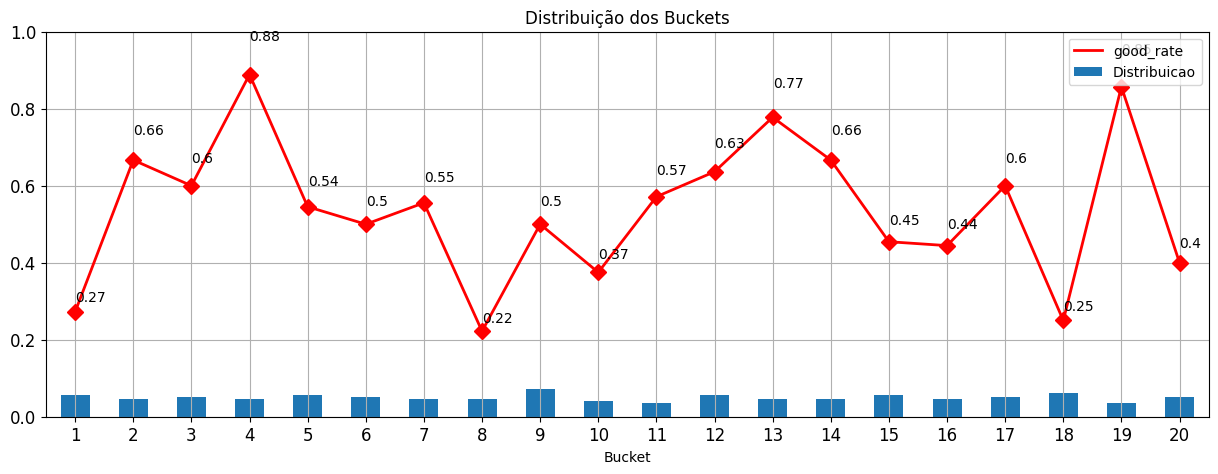

In [27]:
IV_GH_graf = IV_p1[1]
IV_GH_graf['Bucket'] = IV_GH_graf.index+1
IV_GH_graf['Bucket'] = IV_GH_graf['Bucket'].astype(int)
IV_GH_graf = IV_GH_graf.sort_values(by='Bucket')                                     
IV_GH_graf.set_index('Bucket', inplace=True)
#IV_GH_graf

IV_GH_graf['Distribuicao'] = IV_GH_graf.qty / IV_GH_graf.qty.sum()
df_plot_gh_t1 = IV_GH_graf.reset_index().loc[:, ('Bucket', 'Distribuicao')]                                                
df_plot_gh_t1['Bucket'] = df_plot_gh_t1.Bucket.astype(str)
df_plot_gh_t1 = df_plot_gh_t1.set_index('Bucket')

df_plot_gh_t2 = IV_GH_graf.reset_index().loc[:, ('Bucket', 'good_rate')]
df_plot_gh_t2['Bucket'] = df_plot_gh_t2.Bucket.astype(str)
df_plot_gh_t2 = df_plot_gh_t2.set_index('Bucket')

ax = df_plot_gh_t2.good_rate.plot(secondary_y=False, ylim=[0,1], kind="line", rot=0, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(df_plot_gh_t2)):
    ax.annotate(str(int(df_plot_gh_t2.reset_index().iloc[p,1]*100)/100), (int(df_plot_gh_t2.reset_index().iloc[p, 0])-1, df_plot_gh_t2.reset_index().iloc[p, 1] * 1.1))
df_plot_gh_t1.Distribuicao.plot(ylim=[0,1], kind='bar', rot=0, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title="Distribuição dos Buckets")
#display(ax)

## 5.1 Escolher as faixas que podem ser agrupadas

In [28]:
for i in range(len(IV_p1[1].p1_max)):
    #se for o primeiro iniciar com if ao inves de elif
    if i==0:
        print('if p1 <= '+str(IV_p1[1].p1_max.iloc[i])+':')
        print('    return '+ str(i+1))
    #se for o ultimo finalizar com else ao inves de elif
    elif i==(len(IV_p1[1].p1_max))-1:
        print('else:')
        print('    return '+ str(i+1))
    else:
        print('elif p1 <= '+str(IV_p1[1].p1_max.iloc[i])+':')
        print('    return '+ str(i+1))

if p1 <= 0.4044784560690588:
    return 1
elif p1 <= 0.429959586542377:
    return 2
elif p1 <= 0.4395238564209991:
    return 3
elif p1 <= 0.4504720168445367:
    return 4
elif p1 <= 0.4617241896278276:
    return 5
elif p1 <= 0.4626845779359861:
    return 6
elif p1 <= 0.4662474545879491:
    return 7
elif p1 <= 0.4789821395864169:
    return 8
elif p1 <= 0.4841209762192777:
    return 9
elif p1 <= 0.4892764781837766:
    return 10
elif p1 <= 0.4957743125170649:
    return 11
elif p1 <= 0.4985306553551804:
    return 12
elif p1 <= 0.5043213219495309:
    return 13
elif p1 <= 0.5176990040832373:
    return 14
elif p1 <= 0.5255752879347669:
    return 15
elif p1 <= 0.5315918322248252:
    return 16
elif p1 <= 0.5553635511749612:
    return 17
elif p1 <= 0.5760558321456782:
    return 18
elif p1 <= 0.5823378312704967:
    return 19
else:
    return 20


In [29]:
def ratings(p1): 
    if p1 <= 0.2508362656036639:
        return 1
    elif p1 <= 0.6540492277407066:
        return 2
    else:
        return 3

In [30]:
#Criar GHs
datascored_df['GH'] = datascored_df.apply(lambda x: ratings(x['p1']),axis=1).astype(str)

## 5.2 Calcular o IV do GH após a definição das faixas

In [31]:
#Aqui precisa ser somente OOT
IV_GH=calculate_IV(dataframe=datascored_df, coluna_feature='GH', coluna_target=VarTarget)
IV_GH[1];

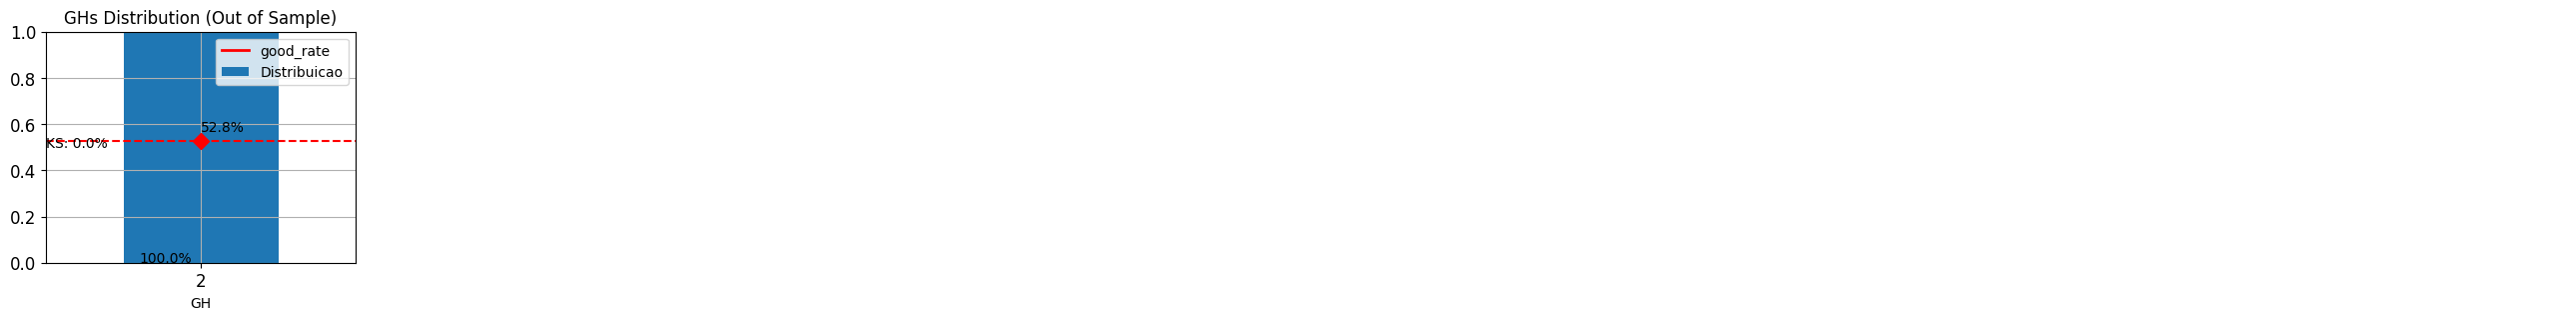

In [32]:
IV_GH_graf = IV_GH[1]
IV_GH_graf['GH'] = IV_GH_graf['GH'].astype(int)
IV_GH_graf = IV_GH_graf.sort_values(by='GH')
IV_GH_graf.set_index('GH', inplace=True)
#IV_GH_graf

IV_GH_graf['Distribuicao'] = IV_GH_graf.qty / IV_GH_graf.qty.sum()
df_plot_gh_t1 = IV_GH_graf.reset_index().loc[:, ('GH', 'Distribuicao')]
df_plot_gh_t1['GH'] = df_plot_gh_t1.GH.astype(str)
df_plot_gh_t1 = df_plot_gh_t1.set_index('GH')

df_plot_gh_t2 = IV_GH_graf.reset_index().loc[:, ('GH', 'good_rate')]
df_plot_gh_t2['GH'] = df_plot_gh_t2.GH.astype(str)
df_plot_gh_t2 = df_plot_gh_t2.set_index('GH')

target_mean = sum(IV_GH[1].qty * IV_GH[1].good_rate) / sum(IV_GH[1].qty)

#calculate o KS in test dataset
kstable = IV_GH_graf.sort_values(by="good_rate", ascending=False).copy()
kstable['events'] = (kstable['qty']*kstable['good_rate'])
kstable['nonevents'] = (kstable['qty']*(1-kstable['good_rate']))
kstable['event_rate'] = (kstable.events / kstable['events'].sum()).apply('{0:.2%}'.format)
kstable['nonevent_rate'] = (kstable.nonevents / kstable['nonevents'].sum()).apply('{0:.2%}'.format)
kstable['cum_eventrate'] = (kstable.events / kstable['events'].sum()).cumsum()
kstable['cum_noneventrate'] = (kstable.nonevents / kstable['nonevents'].sum()).cumsum()
kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
ks = kstable['KS'].max()

ax = df_plot_gh_t2.good_rate.plot(secondary_y=False, ylim=[0,1], kind="line", rot=0, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(df_plot_gh_t2)):
    #ax.annotate(str(int(df_plot_gh_t2.reset_index().iloc[p,1]*100)/100), (int(df_plot_gh_t2.reset_index().iloc[p, 0])-1, df_plot_gh_t2.reset_index().iloc[p, 1] * 1.1))
    ax.annotate(str('{0:.1%}'.format(int(df_plot_gh_t2.reset_index().iloc[p,1]*1000)/1000))\
                ,(df_plot_gh_t2.reset_index().index.values[p]+0.0\
                  ,df_plot_gh_t2.reset_index().iloc[p,1]+0.04))
    ax.annotate(str('{0:.1%}'.format(int(df_plot_gh_t1.reset_index().iloc[p,1]*1000)/1000))\
                ,(df_plot_gh_t1.reset_index().index.values[p]-0.2\
                  ,0))
ax.annotate(str('{0:.1%}'.format(int(target_mean*1000)/1000))\
            ,(7.5\
              ,target_mean))
ax.annotate(str('KS: {0:.1%}'.format(ks)),(len(df_plot_gh_t1)/2-1,0.5))
df_plot_gh_t1.Distribuicao.plot(ylim=[0,1], kind='bar', rot=0, figsize=(4,3), linewidth=2, fontsize=12, grid=True, legend=1, title="GHs Distribution (Out of Sample)")
ax.axhline(y=target_mean, color='r', linestyle='--')
# display(ax)

# 6. Predict Submision dataset using MOJO or H2O Model

In [28]:
test = pd.read_csv('./titanic/test.csv')

In [29]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [30]:
# rename columns for low case
for i in test.columns:    
    test=test.rename(columns={i: i.lower()})

In [31]:
#criar o prefix para a variavel cabine (A, B, C, D, ou E)
test['cabine_prefix'] = test['cabin'].str[0:1]
test = test.fillna(value={'cabine_prefix': 'missing'})

#Tratamento da idade
test['age_mean'] = test['age'].fillna(test['age'].mean())

#Tiket
import re
for i in range(len(test)):
    t=test.loc[i:i,'ticket'].values
    t2=re.sub("[^0-9]", "", str(t))
    t3=re.sub('[^A-Za-z]+', '', str(t))
    if t2 != "":
        test.loc[i:i,'ticket_int']=int(t2)
    if t3 != "":
        if t3 == 'SC':
            t3 = 'SCAHBasle'
        if t3 == 'SOP':
            t3 = 'SOPP'
        if t3 == 'C':
            t3 = 'CA'
        if t3 == 'FC':
            t3 = 'FCC'
        if t3 == 'PP':
            t3 = 'PPP'
        if t3 == 'SCOW':
            t3 = 'Fa'
        if t3 in ('AS', 'CASOTON', 'Fa', 'SCA','SOPP','SOTONO','SP'):
            t3='LOW'
        test.loc[i:i,'ticket_str']=str(t3)

test['ticket_int'] = test['ticket_int'].fillna(0)
test = test.fillna(value={'ticket_str': 'missing'})


#Name: Criar uma categoria com o titulo do nome
for i in range(len(test)):
    t1 = str(test.loc[i:i,'name'].values)
    t2 = t1[0:t1.find('.')].split()[-1]
    if t2 in ('Rev', 'Capt', 'Don', 'Jonkheer'):
        t2='LOW'
    if t2 in ('Lady', 'Mme'):
        t2='Miss'
    test.loc[i:i,'nametitle']=str(t2)

#Numeric features must be float type
for col_name in NUM:    
    test[col_name] = test[col_name].astype(float)    

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:        
    test[col_name] = test[col_name].astype(str)    
    test = test.fillna(value={col_name: 'missing'}) 

In [32]:
#Importar MOJO

test_tmp = h2o.mojo_predict_pandas(test, path_model_mojo)    
predict_df = test.merge(test_tmp, left_index=True, right_index=True)
    
predict_df.rename(columns={'predict':'Survived', 'passengerid': 'PassengerId'}, inplace=True)
predict_df = predict_df.reset_index(drop=True)
predict_df = predict_df.loc[:, ('PassengerId', 'Survived')]
predict_df

Detected 7 unused columns in the input data set: {,ticket,sex,cabin,name,passengerid,age}


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## 8.1 Save final dataset with predictions for submissions in https://www.kaggle.com/competitions/titanic/submissions

In [33]:
predict_df.loc[:, ('PassengerId', 'Survived')].to_csv('./titanic/titanic_submission.csv', index=False)

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)


In [20]:
datascored_df

,predict,p0,p1,p2,p3,p4,p5,relevanceScore,age,headlineWordCount,postTextWordCount,tagsWordCount
0,2,4.677634638346923e-08,1.1676696361755017e-15,0.9999999489608964,3.407394138177412e-15,2.977178123544723e-11,4.232980931791508e-09,15.0,51.0,4.0,17.0,2.0
1,2,2.0272777614570523e-08,5.7686188917280105e-15,0.9999999790458972,1.971193879518403e-15,6.773761240904898e-11,6.135798895751874e-10,19.0,51.0,8.0,16.0,1.0
2,2,9.294378391378803e-08,2.2545191107957835e-15,0.9999999001672836,8.0938210653409e-15,4.745537734168081e-11,6.841466768514429e-09,15.0,48.0,4.0,17.0,2.0
3,2,3.91454474532173e-08,9.321817772241527e-15,0.9999999475186072,1.2670795194126462e-14,1.0142605099650907e-10,1.3234497555376049e-08,3.0,65.0,3.0,27.0,2.0
4,3,7.702488493523723e-08,3.697063729579029e-09,1.3047987517837838e-12,0.9999999064090408,5.305585504278394e-13,1.2867175297856844e-08,38.0,24.0,5.0,26.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
190,4,1.7630402441076385e-15,2.493344972239093e-08,2.1418575899431918e-11,9.431461366546218e-16,0.9999999749266693,1.1845957680979096e-10,96.0,55.0,7.0,12.0,3.0
191,5,5.670130621767176e-15,3.773518700156599e-15,4.874495883520789e-11,1.785648901286832e-08,1.1855918236176838e-10,0.9999999819761974,58.0,50.0,4.0,23.0,3.0
192,4,1.7459390709047226e-15,2.4814589710135068e-08,2.0661009866167e-11,9.320344601321404e-16,0.9999999750423136,1.2243302447670744e-10,96.0,68.0,7.0,12.0,3.0
193,4,3.533097171061122e-16,9.664277098027769e-09,2.3075069521265707e-12,1.0234772118176088e-15,0.9999999901533704,1.8004385349042468e-10,80.0,69.0,6.0,25.0,1.0


In [21]:
# using only Spending_Score and income variable for easy visualisation
X = datascored_df.iloc[:, [7, 8]].values

In [22]:
# Using the elbow method to find the optimal number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


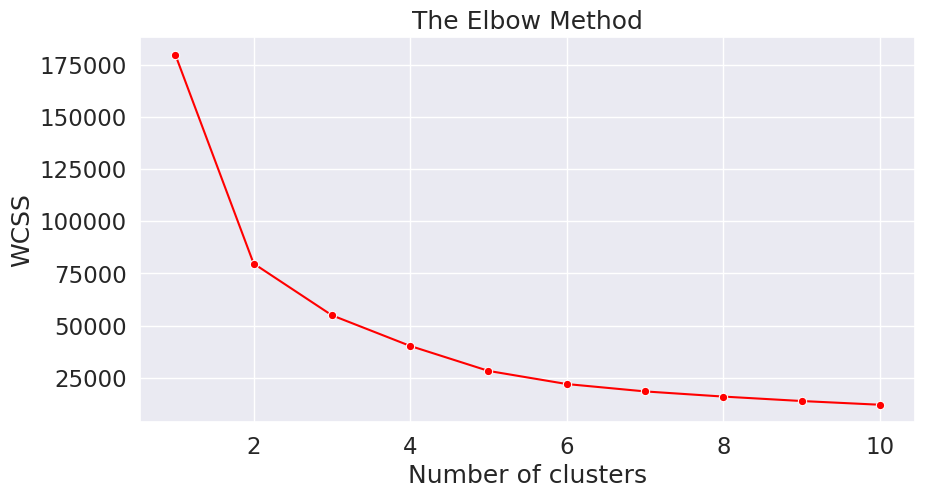

In [23]:
plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [24]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argumen

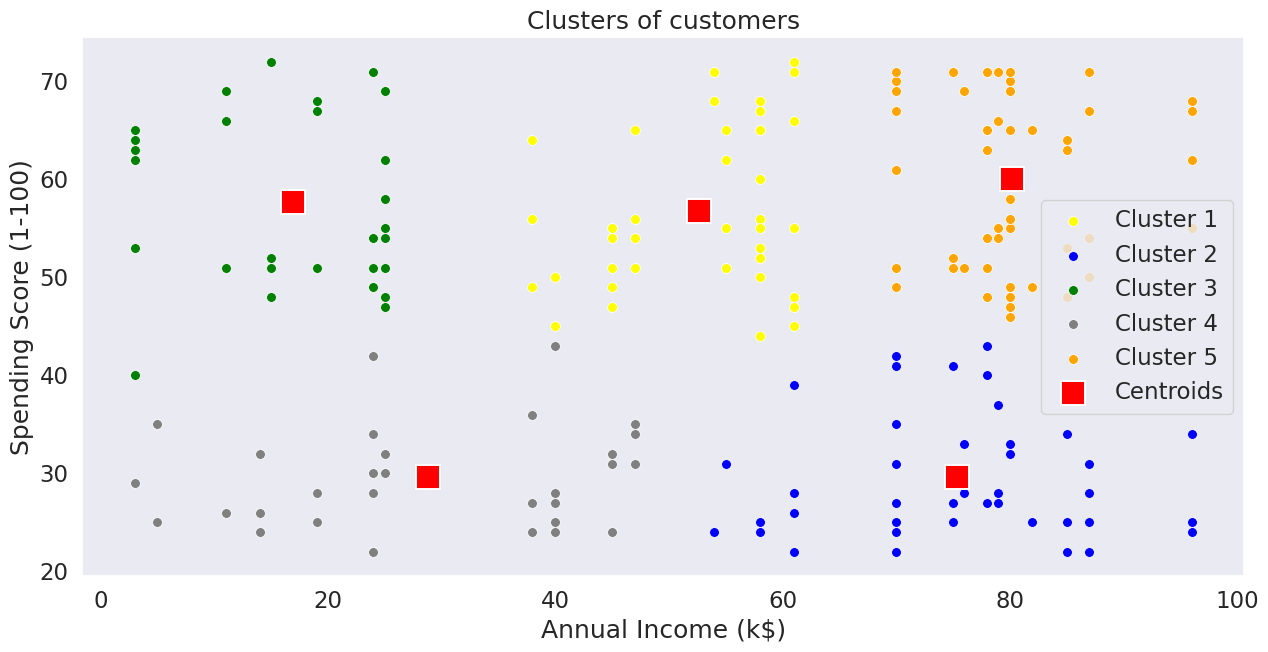

In [25]:
# Visualising the clusters
plt.figure(figsize=(15,7))
sns.scatterplot(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], color = 'yellow', label = 'Cluster 1',s=50)
sns.scatterplot(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], color = 'blue', label = 'Cluster 2',s=50)
sns.scatterplot(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], color = 'green', label = 'Cluster 3',s=50)
sns.scatterplot(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], color = 'grey', label = 'Cluster 4',s=50)
sns.scatterplot(X[y_kmeans == 4, 0], X[y_kmeans == 4, 1], color = 'orange', label = 'Cluster 5',s=50)
sns.scatterplot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color = 'red', 
                label = 'Centroids',s=300,marker=',')
plt.grid(False)
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()